In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
def load_data():
    data = {}
    data["train"] = pd.read_csv("input/train.csv")
    data["test"] = pd.read_csv("input/test.csv")
    data["event_type"] = pd.read_csv("input/event_type.csv")
    data["resource_type"] = pd.read_csv("input/resource_type.csv")
    data["severity_type"] = pd.read_csv("input/severity_type.csv")
    data["log_feature"] = pd.read_csv("input/log_feature.csv")
    return data

data = load_data()

In [3]:
y_train = data["train"]["fault_severity"].rename(index=data["train"]["id"])

### location!

In [4]:
# label encode and train population
location_count = data["train"].groupby("location")["id"].agg(len).rename("count")
train_location_encoded = pd.DataFrame()
train_location_encoded["location_num"] = data["train"]["location"].apply(
    lambda x: int(x.split()[1]))
train_location_encoded["location_count"] = data["train"]["location"].apply(
    lambda x: location_count.ix[x])
train_location_encoded.rename(index=data["train"]["id"], inplace=True)
# if location is not on test file, then count = 0
test_location_encoded = pd.DataFrame()
test_location_encoded["location_num"] = data["test"]["location"].apply(
    lambda x: int(x.split()[1]))
test_location_encoded["location_count"] = data["test"]["location"].apply(
    lambda x: location_count.ix[x] if x in location_count.index else 0)
test_location_encoded.rename(index=data["test"]["id"], inplace=True)

### event_type!

In [5]:
# one-hot encoding, not worry about columns which not in train_event_type
event_type_encoded = pd.get_dummies(data["event_type"], columns=["event_type"],
                                    prefix="").groupby("id").agg(sum)

In [6]:
train_event_type_table = data["train"]["id"].to_frame().merge(
    event_type_encoded, how="left", left_on="id", right_index=True)
event_type_features_ordered = train_event_type_table.drop("id", axis=1).T.sum(
    axis=1).sort_values().index.tolist()
event_type_features_to_drop = event_type_features_ordered[:-15]
event_type_encoded["event_type_count"] = data["event_type"].groupby("id").agg(
    lambda x: sum([y not in event_type_features_to_drop for y in x]) if len(x)!= 0 else 0)

### severity_type!

In [7]:
# one hot encode and numeric encode
severity_type_encoded = pd.get_dummies(data["severity_type"], columns=["severity_type"],
                                       prefix="")
severity_type_encoded["severity_type_num"] = data["severity_type"]["severity_type"].apply(
    lambda x: int(x.split()[1]))
severity_type_encoded["severity_type_time"] = data["severity_type"].index + 1
severity_type_encoded["severity_type_time_log"] = np.log(data["severity_type"].index + 1)

In [8]:
# magic feature
time_table = data["severity_type"].merge(pd.concat([data["train"], data["test"]]),
                                         how="left", left_on="id", right_on="id")
time_array = [1]
location = "location 1"
t = 1
for i in range(1, time_table.shape[0]):
    if time_table["location"][i] == location:
        t += 1
    else:
        t = 1
        location = time_table["location"][i]
    time_array.append(t)

time_norm_array = []
start = 0
location = "location 1"
for i in range(1, time_table.shape[0]+1):
    if (i == time_table.shape[0]) or (time_table["location"][i] != location):
        time_norm_array += list(np.arange(1, i-start+1)/(i-start))
        if i < time_table.shape[0]:
            location = time_table["location"][i]
            start = i

In [9]:
severity_type_encoded["severity_type_time_new"] = time_array
severity_type_encoded["severity_type_time_norm_new"] = time_norm_array
severity_type_encoded.set_index("id", inplace=True)

### resource_type!

In [10]:
# one hot encode and count
resource_type_encoded = pd.get_dummies(data["resource_type"], columns=["resource_type"],
                                       prefix="").groupby("id").agg(sum)
resource_type_encoded["resource_type_count"] = resource_type_encoded.apply(sum, axis=1)

### log_feature

In [11]:
def get_log_feature_list(log_data, train_data_index):
    l = {}
    for i in range(log_data.shape[0]):
        if log_data["id"][i] in train_data_index:
            log = log_data["log_feature"][i]
            l[log] = log_data["volume"][i] + (l[log] if log in l else 0)
    return pd.DataFrame.from_dict(l, orient="index")

In [12]:
log_feature_list = get_log_feature_list(data["log_feature"], data["train"]["id"])
log_features_ordered = log_feature_list.sort_values(0).index.tolist()

In [13]:
# one hot encode
log_features_to_get = ["_" + x for x in log_features_ordered[-90:]]
log_feature_table = pd.get_dummies(data["log_feature"], columns=["log_feature"], prefix="")[
    log_features_to_get+["volume"]]
log_feature_table = log_feature_table.multiply(log_feature_table["volume"], axis="index").drop(
    ["volume"], axis=1)
log_feature_table["id"] = data["log_feature"]["id"]
log_feature_encoded = log_feature_table.groupby("id").agg(sum)

In [14]:
log_features_2_to_get = ["log_" + x for x in log_features_ordered[-50:]]
log_feature_table_2 = pd.get_dummies(data["log_feature"], columns=["log_feature"], prefix="log")[
    log_features_2_to_get+["volume"]]
log_feature_table_2 = log_feature_table_2.multiply(np.log(log_feature_table_2["volume"]+1), axis="index").drop(
    ["volume"], axis=1)
#log_feature_table_2 = log_feature_table_2.multiply(np.ones(len(log_feature_table_2["volume"])), axis="index").drop(
#    ["volume"], axis=1)
log_feature_table_2["id"] = data["log_feature"]["id"]
log_feature_encoded_2 = log_feature_table_2.groupby("id").agg(sum)

### merge!

In [15]:
X_train = data["train"]["id"].to_frame().rename(index=data["train"]["id"])
X_test = data["test"]["id"].to_frame().rename(index=data["test"]["id"])
features = []
features_to_scale = []
# event_type
X_train = X_train.merge(event_type_encoded, how="left", left_index=True, right_index=True)
X_test = X_test.merge(event_type_encoded, how="left", left_index=True, right_index=True)
# resource_type
X_train = X_train.merge(resource_type_encoded, how="left", left_index=True, right_index=True)
X_test = X_test.merge(resource_type_encoded, how="left", left_index=True, right_index=True)
# severity_type
X_train = X_train.merge(severity_type_encoded, how="left", left_index=True, right_index=True)
X_test = X_test.merge(severity_type_encoded, how="left", left_index=True, right_index=True)
# location
X_train = X_train.merge(train_location_encoded, how="left", left_index=True, right_index=True)
X_test = X_test.merge(test_location_encoded, how="left", left_index=True, right_index=True)
# log feature
X_train = X_train.merge(log_feature_encoded, how="left", left_index=True, right_index=True)
X_test = X_test.merge(log_feature_encoded, how="left", left_index=True, right_index=True)
# log feature 2
#X_train = X_train.merge(log_feature_encoded_2, how="left", left_index=True, right_index=True)
#X_test = X_test.merge(log_feature_encoded_2, how="left", left_index=True, right_index=True)

### xgboost!

In [16]:
import xgboost as xgb

In [17]:
def modelfit(model, data, label, cv=5, early_stopping_rounds=50):
    params = model.get_params()
    params["num_class"] = 3
    dtrain = xgb.DMatrix(data, label)
    cvresult = xgb.cv(params, dtrain, num_boost_round=model.get_params()["n_estimators"],
                      nfold=cv, stratified=True,
                      metrics="mlogloss", early_stopping_rounds=early_stopping_rounds, verbose_eval=50)
    print(cvresult.iloc[-1])

### base model

In [18]:
features_to_drop = ["id"] + event_type_features_to_drop + ["severity_type_num", "severity_type_time"]
features_to_drop += ["severity_type_time_norm_new"]
X_train1 = X_train.drop(features_to_drop, axis=1)

In [19]:
# best CV: 50: 0.467595? 0.470453 60: 0.467124 70: 0.466541 90: 0.455883 0.449237
# max_depth > 7 < 11 ~ 8
xgb1 = xgb.XGBClassifier(n_estimators=1000,
                         max_depth=8,
                         subsample=0.8, colsample_bytree=0.8,
                         objective="multi:softprob")
modelfit(xgb1, X_train1, y_train)

[0]	train-mlogloss:1.01954+0.00182932	test-mlogloss:1.02506+0.00143578
[50]	train-mlogloss:0.325796+0.00201706	test-mlogloss:0.46783+0.00948525
[100]	train-mlogloss:0.247652+0.00326281	test-mlogloss:0.450089+0.00933339
[150]	train-mlogloss:0.200665+0.00262628	test-mlogloss:0.449651+0.00954034
test-mlogloss-mean     0.448676
test-mlogloss-std      0.009418
train-mlogloss-mean    0.217604
train-mlogloss-std     0.003173
Name: 130, dtype: float64


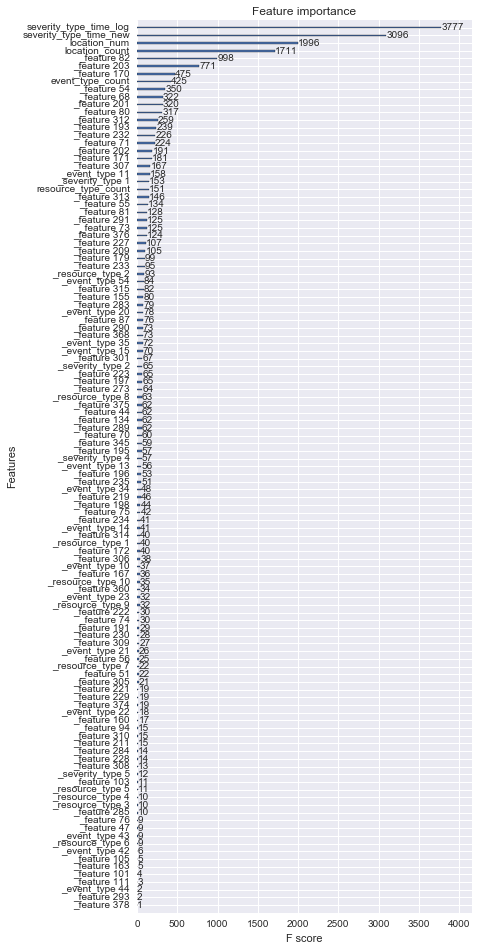

In [20]:
xgb1x = xgb.XGBClassifier(n_estimators=126,
                          max_depth=8,
                          subsample=0.8, colsample_bytree=0.8,
                          objective="multi:softprob")
xgb1x.fit(X_train1, y_train, eval_metric="mlogloss")
fig, ax = plt.subplots(figsize=(6, 16))
xgb.plot_importance(xgb1x, ax)

In [21]:
y_test = xgb1x.predict_proba(X_test.drop(features_to_drop, axis=1))
sample = pd.read_csv("input/sample_submission.csv")
sample["predict_0"] = y_test[:,0]
sample["predict_1"] = y_test[:,1]
sample["predict_2"] = y_test[:,2]
sample.to_csv("submit/xgb1x.csv", index=False)

### test model

In [22]:
# list unimportant features to drop
#features_to_drop = ["id"] + event_type_features_ordered[:-15] + ["severity_type_num"] 
#xgb2 = xgb.XGBClassifier(n_estimators=1000,
#                         subsample=0.8, colsample_bytree=0.8,
#                         objective="multi:softprob")
#modelfit(xgb2, X_train.drop(features_to_drop, axis=1), y_train, cv=5)

In [23]:
# grid search